In [43]:
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='svg'

# 数据预处理

- 移除和填充数据集中缺失的值
- 将分类数据转为机器学习算法需要的形式
- 选择相关的特征用于模型建立

## 处理缺失的数据

In [44]:
# 从CSV文件中创建一个简单样本数据的dataframe
import pandas as pd
from io import StringIO
csv_data = '''A,B,C,D
            1.0,2.0,3.0,4.0
            5.0,6.0,,8.0
            10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))
df


,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [45]:
# 获取每一列缺失值的总个数
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

### 剔除带有缺失值的样本或特征

In [46]:
# 通过 dropna() 移除有缺失值的行
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [47]:
# 移除有缺失值的列
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [48]:
# 只丢弃所有列都是NaN的行
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [49]:
# 丢弃不足四个非NaN值的行
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [50]:
# 只丢弃NaN值出现在指定列的行
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


### 填充缺失值
> 插值技术

In [51]:
# 使用mean imputation完成缺失值的填充
import numpy as np
from sklearn.impute import SimpleImputer  # instead of Imputer
# axis=0 ,notes: missing_values=np.nan instead of missing_values='NaN'
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data


array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

## 处理分类数据

In [52]:
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1']
])
df.columns = ['color', 'size', 'price', 'classlabel']
df


,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### 映射ordinal特征

In [53]:
size_mapping = {'XL': 3, 'L': 2, 'M': 1}
df['size'] = df['size'].map(size_mapping)
df


,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [54]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}


### 编码类标

In [55]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping


{'class1': 0, 'class2': 1}

In [56]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df


,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [57]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df


,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [58]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y


array([0, 1, 0])

In [59]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### 在nominal特征上执行one-hot编码

In [60]:
# 使用LabelEncoder
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X


array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [61]:
# 使用OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()


array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [62]:
# 使用pandas中的get_dummie方法实现,该方法只转化字符串型的列
pd.get_dummies(df[['price', 'color', 'size']])


,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


## 将数据集分为训练集和测试集

In [63]:
# 读取Wine数据从UCI上
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                   'Magnesium', 'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()


Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [64]:
# 使用train_test_split划分数据集
from sklearn.model_selection import train_test_split
import sklearn
print(sklearn.__version__)
# 当前版本的train_test_split已经移动到了model_selection下了
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


0.20.3


## 将特征缩放到一个相同的尺度上

常见的方式有两种 normalization 和 standardization
- normalization
\begin{equation}
x_{norm}^{(i)}=\frac{x^{(i)}-x_{min}}{x_{max}-x_{min}}
\end{equation}
- standardization
\begin{equation}
x_{std}^{(i)}=\frac{x^{(i)}-\mu_x}{\sigma_x}
\end{equation}

In [65]:
# 使用normalization
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
print(X_train.shape,X_test.shape)
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)


(124, 13) (54, 13)


In [66]:
# 使用standardization
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## 选择有意义的特征

减小泛化误差的常用方法
- 收集更多的数据
- 通过正则化引入惩罚
- 选择带有更少参数的简单模型
- 降低数据的维度

### 具有L1正则化的稀疏解

In [67]:
# 使用L1正则化
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [68]:
# 将其应用到标准化的Wine数据上
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))


Training accuracy: 0.9838709677419355
Test accuracy: 0.9814814814814815


In [69]:
# intercept term
lr.intercept_

array([-0.38379775, -0.15807248, -0.70041965])

In [70]:
# 模型参数
lr.coef_ # (n_class,weight_size)

array([[ 0.28028713,  0.        ,  0.        , -0.02795808,  0.        ,
         0.        ,  0.71011972,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23617007],
       [-0.64398371, -0.06875535, -0.05722411,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92673918,
         0.0601771 ,  0.        , -0.37106759],
       [ 0.        ,  0.06152241,  0.        ,  0.        ,  0.        ,
         0.        , -0.63603635,  0.        ,  0.        ,  0.49808462,
        -0.35816044, -0.57123978,  0.        ]])

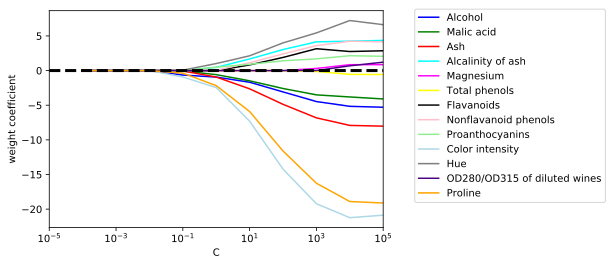

In [71]:
# 下面对不同的正则化强度下,不同特征的权重系数的进行画图
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4, 6, dtype=float):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column+1], color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)


### 顺序特征选择

sequential backward selection(SBS) 是一个经典的顺序特征选择算法

In [72]:
# SBS算法并没有在scikit-learn中实现,所以我们下面自己实现它
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score


class SBS(object):
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = estimator
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._cal_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._cal_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])

        self._k_score_ = self.scores_[-1]
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _cal_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score


In [73]:
# 使用KNN分类器来测试SBS
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)


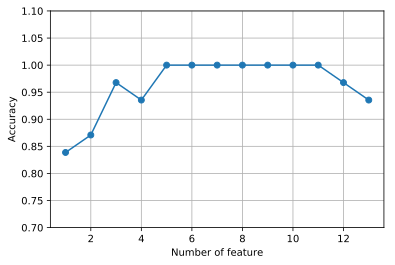

In [74]:
# KNN分类准确度的图
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim(0.7, 1.1)
plt.ylabel('Accuracy')
plt.xlabel('Number of feature')
plt.grid()


In [75]:
# 获取是哪5个特征产生这么好的性能
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [76]:
# 测试KNN分类器在原始测试集上的性能表现
knn.fit(X_train_std,y_train)
print('Training accuracy:',knn.score(X_train_std,y_train))
print('Test accuracy:',knn.score(X_test_std,y_test))

Training accuracy: 0.9838709677419355
Test accuracy: 0.9444444444444444


In [77]:
# 测试KNN分类器在选择了上述5个特征后的良好表现
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))


Training accuracy: 0.9596774193548387
Test accuracy: 0.9629629629629629


In [78]:
# 使用随机森林获取特征重要程度
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("{:2d}) {:30s} {:5f}".format(f+1, feat_labels[indices[f]], importances[indices[f]]))


 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


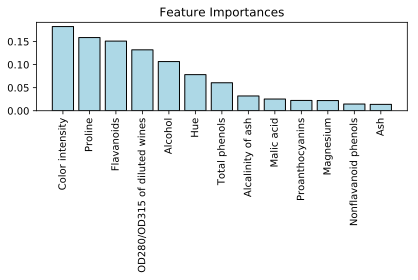

In [80]:
# 绘画上述数据的柱状图
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center', edgecolor="black")
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.tight_layout()
